# Predict stock prices  with Long short-term memory (LSTM)

https://colab.research.google.com/github/rawar/tensorflow-notebooks/blob/master/stock_price_prediction_keras.ipynb

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet. 

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [81]:
!pip install tensorflow

In [82]:
!pip install pandas-datareader

In [83]:
#!apt install graphviz

In [84]:
!pip install pydot pydot-ng

## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

In [86]:
tickers = 'AAPL'

start_date = '1980-12-01'
end_date = '2018-12-31'

# stock_data = data.get_data_yahoo(tickers, start_date, end_date)
stock_data = pd.read_csv('data/IBM.csv')

In [87]:
stock_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,1.591517,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,1.605428,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,1.589431,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,1.558129,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,1.528913,572685
5,1962-01-09,7.036329,7.176546,7.036329,7.087317,1.546999,517770
6,1962-01-10,7.100064,7.131931,7.100064,7.100064,1.549782,313800
7,1962-01-11,7.119184,7.176546,7.119184,7.176546,1.566476,337335
8,1962-01-12,7.189293,7.240280,7.189293,7.189293,1.569259,462855
9,1962-01-15,7.214786,7.237094,7.214786,7.221160,1.576214,266730


In [88]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,15463.000000,15463.000000,15463.000000,15463.000000,15463.000000,1.546300e+04
mean,61.111289,61.677502,60.573133,61.129956,38.668987,5.096442e+06
std,55.633604,56.087379,55.209324,55.657655,43.008059,4.631450e+06
min,3.900574,4.098152,3.824092,3.900574,0.851656,0.000000e+00
25%,15.580186,15.684751,15.471887,15.571971,4.287597,1.501428e+06
50%,28.979446,29.248327,28.740440,28.979446,12.144572,4.317470e+06
75%,110.498325,111.735184,108.838428,110.430211,64.521584,7.072529e+06
max,205.908218,206.405350,204.875717,206.309753,146.742050,7.263916e+07


In [89]:
stock_data_len = stock_data['Close'].count()
print(stock_data_len)

15463


I'm only interested in *close* prices

In [90]:
close_prices = stock_data.iloc[:, 1:2].values
print(close_prices)

[[  7.374124]
 [  7.291268]
 [  7.355003]
 ...
 [130.380005]
 [133.119995]
 [132.429993]]


Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [91]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['1980-12-01', '1980-12-02', '1980-12-03', '1980-12-04',
               '1980-12-05', '1980-12-08', '1980-12-09', '1980-12-10',
               '1980-12-11', '1980-12-12',
               ...
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', length=9936, freq='B')


In [92]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method='ffill')

In [93]:
close_prices.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,1.591517,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,1.605428,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,1.589431,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,1.558129,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,1.528913,572685
5,1962-01-09,7.036329,7.176546,7.036329,7.087317,1.546999,517770
6,1962-01-10,7.100064,7.131931,7.100064,7.100064,1.549782,313800
7,1962-01-11,7.119184,7.176546,7.119184,7.176546,1.566476,337335
8,1962-01-12,7.189293,7.240280,7.189293,7.189293,1.569259,462855
9,1962-01-15,7.214786,7.237094,7.214786,7.221160,1.576214,266730


The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [94]:
training_set = close_prices.iloc[:, 1:2].values

In [95]:
print(training_set)

[[  7.374124]
 [  7.291268]
 [  7.355003]
 ...
 [130.380005]
 [133.119995]
 [132.429993]]


In [96]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

(15463, 1)


LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [97]:
features = []
labels = []
for i in range(60, stock_data_len):
    features.append(training_set_scaled[i-60:i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [98]:
print(labels)

[0.01457643 0.01473419 0.01457643 ... 0.6261121  0.6396759  0.63626018]


In [99]:
print(features)

[[[0.01719514]
  [0.01678498]
  [0.01710049]
  ...
  [0.01511279]
  [0.01520744]
  [0.01511279]]

 [[0.01678498]
  [0.01710049]
  [0.01669033]
  ...
  [0.01520744]
  [0.01511279]
  [0.01457643]]

 [[0.01710049]
  [0.01669033]
  [0.01599621]
  ...
  [0.01511279]
  [0.01457643]
  [0.01473419]]

 ...

 [[0.61670647]
  [0.61581545]
  [0.60502378]
  ...
  [0.62205282]
  [0.61685498]
  [0.61650849]]

 [[0.61581545]
  [0.60502378]
  [0.60022198]
  ...
  [0.61685498]
  [0.61650849]
  [0.6261121 ]]

 [[0.60502378]
  [0.60022198]
  [0.60685537]
  ...
  [0.61650849]
  [0.6261121 ]
  [0.6396759 ]]]


Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 days of values and features [2] contains the  ...

In [100]:
print(features.shape)

(15403, 60, 1)


## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [101]:
import tensorflow as tf

In [102]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])

2023-06-08 00:54:57.966999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 00:54:57.968740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 00:54:57.969962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [103]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [104]:
#tf.keras.utils.plot_model(model, to_file='my_model.png')


In [105]:
# Run tensorboard with the logdir
#import os
#LOG_BASE_DIR = './log'
#os.makedirs(LOG_BASE_DIR, exist_ok=True)

In [106]:
#!ls -l log

## Load the Colab TensorBoard extention and start TensorBoard inline

In [107]:
#%load_ext tensorboard.notebook
#%tensorboard --logdir {LOG_BASE_DIR}

## Define a TensorBoard callback

In [108]:
#import datetime
#logdir = os.path.join(LOG_BASE_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [109]:
#from tensorflow.keras.callbacks import TensorBoard

#tbCallBack = TensorBoard(logdir,histogram_freq=1)

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [110]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [111]:
#import os
#print(os.environ)

In [112]:
#tf.test.gpu_device_name()

In [113]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [114]:
from time import time
start = time()
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)
end = time()

Epoch 1/20


2023-06-08 00:54:58.928837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 00:54:58.930554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 00:54:58.931836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

482/482 [==============================] - 69s 132ms/step - loss: 0.0032
Epoch 2/20
482/482 [==============================] - 63s 131ms/step - loss: 0.0015
Epoch 3/20
482/482 [==============================] - 64s 132ms/step - loss: 0.0012
Epoch 4/20
482/482 [==============================] - 64s 133ms/step - loss: 0.0011
Epoch 5/20
482/482 [==============================] - 65s 135ms/step - loss: 9.5154e-04
Epoch 6/20
482/482 [==============================] - 64s 132ms/step - loss: 9.1192e-04
Epoch 7/20
482/482 [==============================] - 63s 131ms/step - loss: 9.2427e-04
Epoch 8/20
482/482 [==============================] - 64s 132ms/step - loss: 8.6958e-04
Epoch 9/20
482/482 [==============================] - 64s 132ms/step - loss: 8.7093e-04
Epoch 10/20
482/482 [==============================] - 64s 133ms/step - loss: 8.4144e-04
Epoch 11/20
482/482 [==============================] - 65s 134ms/step - loss: 7.6271e-04
Epoch 12/20
482/482 [==============================] - 64

In [115]:
print('Total training time {} seconds'.format(end - start))

Total training time 1279.3490583896637 seconds


### Save the model

In [116]:
# tf.keras.models.save_model(model, 'stocks/1')

In [117]:
#  [samples, days, features]
print(features.shape)

(15403, 60, 1)


In [118]:
testing_start_date = '2019-01-01'
testing_end_date = '2019-04-10'

# test_stock_data = data.get_data_yahoo(tickers, testing_start_date, testing_end_date)
test_stock_data = pd.read_csv('data/IBM.csv')

In [119]:
test_stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
15458,2023-05-31,128.509995,129.440002,127.459999,128.589996,128.589996,11590200
15459,2023-06-01,128.440002,130.149994,127.779999,129.820007,129.820007,4136100
15460,2023-06-02,130.380005,133.119995,130.149994,132.419998,132.419998,5373900
15461,2023-06-05,133.119995,133.580002,132.270004,132.639999,132.639999,3993500
15462,2023-06-06,132.429993,132.940002,131.880005,132.690002,132.690002,3297100


In [120]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values


In [139]:
# BK - Reduce the test set to 60 days
test_stock_data_processed = test_stock_data_processed[-60:]

In [140]:
print(test_stock_data_processed.shape)

(60, 1)


In [141]:
all_stock_data = pd.concat((stock_data['Close'], test_stock_data['Close']), axis = 0)

In [142]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [143]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i-60:i, 0])

In [144]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

3/3 [==============================] - 0s 20ms/step


In [145]:
print(predicted_stock_price.shape)
print(test_stock_data_processed.shape)

(69, 1)
(60, 1)


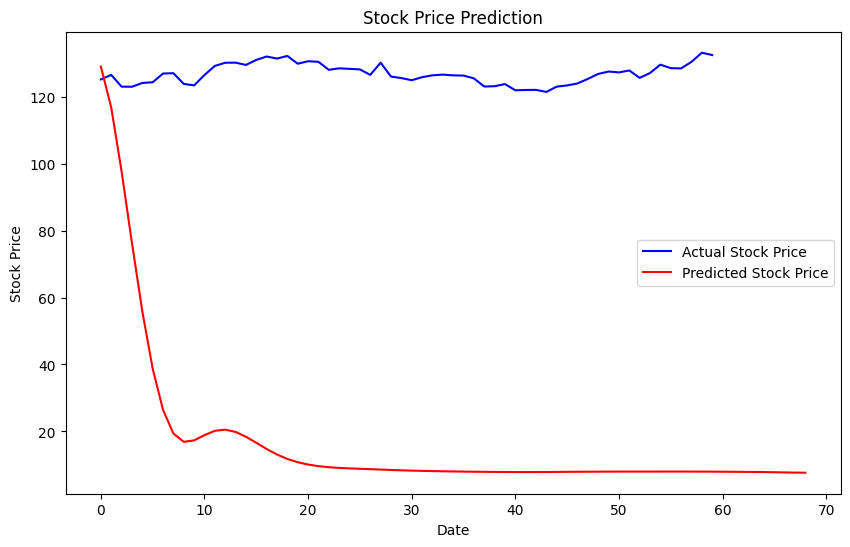

In [147]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Stock Price')  
plt.title('Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()  

In [128]:
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)


test_inputs = test_stock_data_processed.reshape(-1,1)
test_inputs = sc.transform(test_inputs)


print(test_inputs.shape)

(15463, 1)


In [129]:
test_features = []
for i in range(60, 291):
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)

In [130]:
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  
print(test_features.shape)

(231, 60, 1)


In [131]:
predicted_stock_price = model.predict(test_features)

8/8 [==============================] - 0s 30ms/step


In [132]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

(231, 1)


In [133]:
print(test_stock_data_processed.shape)

(15463, 1)


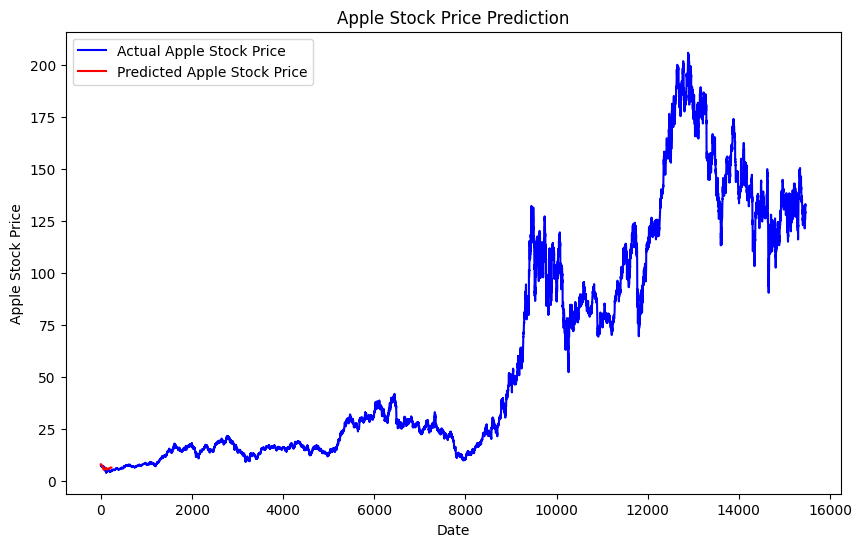

In [134]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  

## Download the model and the weights

In [135]:
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
files.download("model.json")

In [ ]:
model.save('weights.h5')
files.download('weights.h5')